In [ ]:
from classes import *
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec
from sklearn.metrics import balanced_accuracy_score

In [2]:
hm_dir = '/root/SRCclusters/results/EDZcode/10Dec2025/'  # 5Nov2025/' # 8Jul2025/'
geomorph_path = hm_dir + 'network/reach_data.csv'
edz_path = hm_dir + 'analysis/data.csv'
reaches = ReachData(geomorphic_data_path=geomorph_path, edz_data_path=edz_path)
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(10), 'return_estimator': True, 'scoring': 'balanced_accuracy'})
reaches.attach_rfhandler(rf)

Input data shape: (197, 122)

Unconfined reaches without an extracted EDZ:
                    Segment Ph2SedReg
SRC_ID                               
1             118_M15T1.03A       DEP
41            118_M40T5.01C     FSTCD
45            118_M40T5.03A       UST
53            118_M41T6.02B       UST
80      19_M05T03.02S01.02B      CEFD
129                 26_M02-     FSTCD
181                 27_M23-       UST
188               27_T4.02A       UST
189               27_T4.02B     FSTCD
190               27_T4.05A       UST
193               27_T4.05D       UST
194                177_M12A       DEP

Shape after dropping unconfined NaNs: (185, 122)
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
TR       26
CST       8
DEP       5
Name: count, dtype: int64



In [3]:
reach_avg_dir = hm_dir + 'geometry/'
reaches.load_reach_avg_profiles(reach_avg_dir)

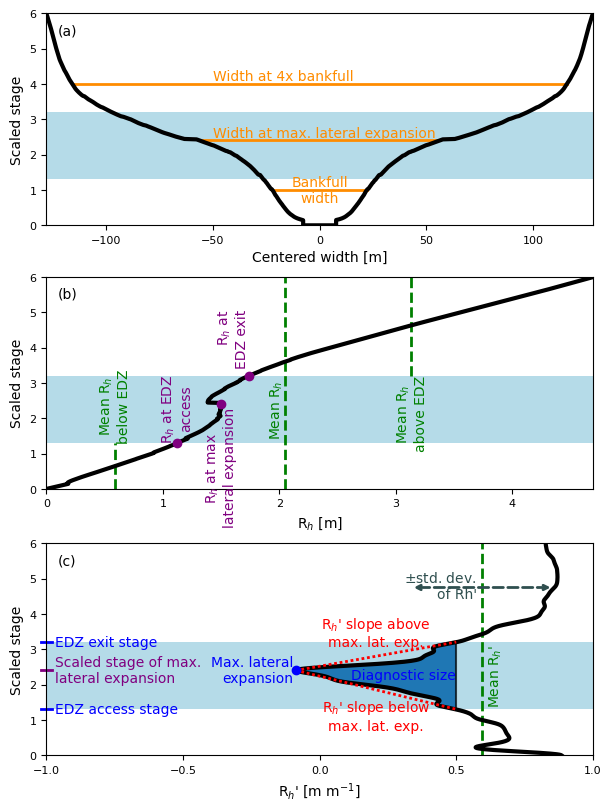

In [4]:
fig = reaches.plot_edz_feature_descriptions()
#fig.savefig(hm_dir + 'figs/dem_feat_desc.tif', dpi=300, bbox_inches='tight')

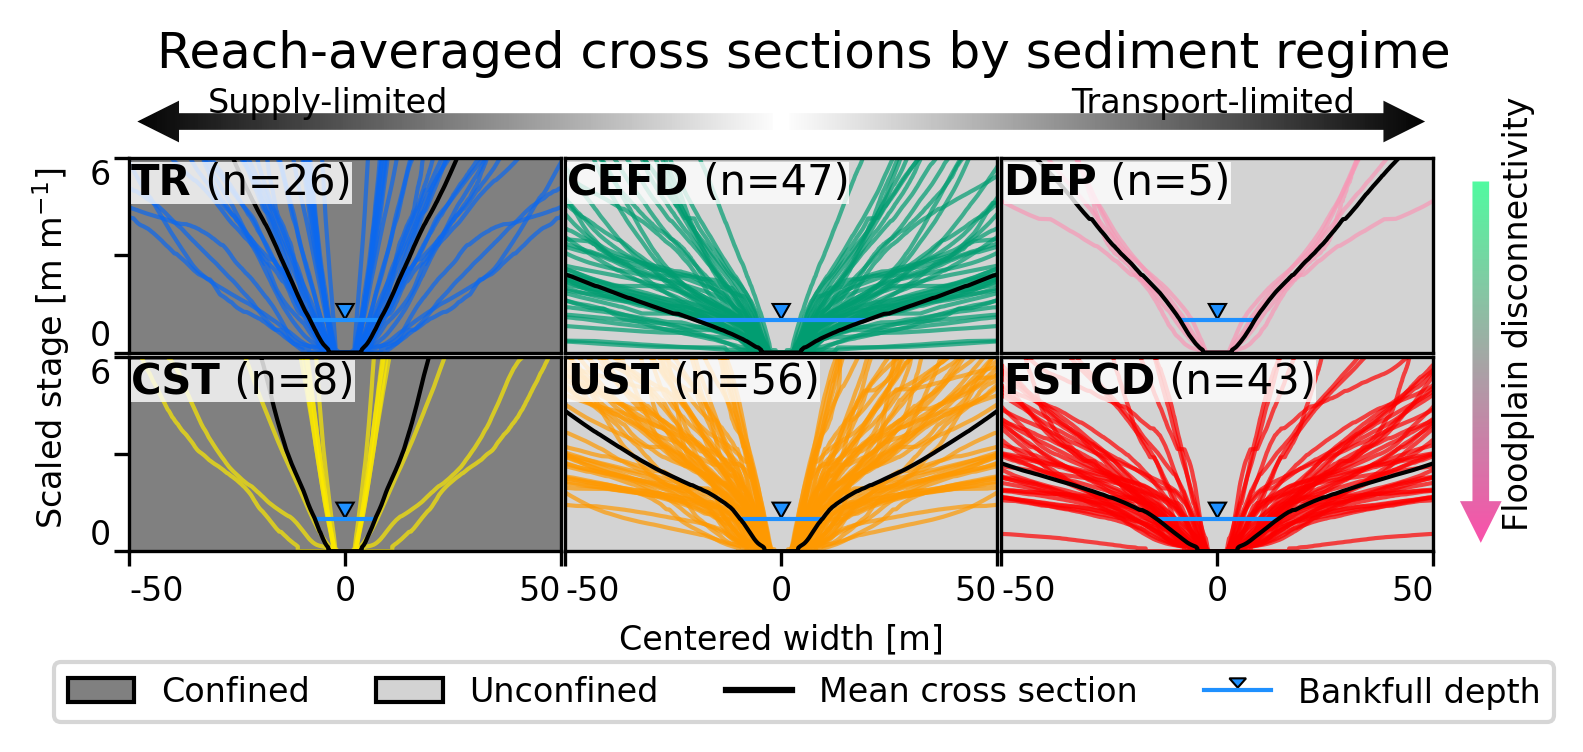

In [5]:
fig = reaches.plot_reconstructed_xsecs_paper()
#fig.savefig(hm_dir + 'figs/xsecs.tif', dpi=300, bbox_inches='tight')

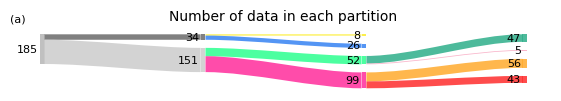

In [6]:
fig = reaches.plot_sankey_diagram()
#fig.savefig(hm_dir + 'figs/sankey.tif', dpi=300, bbox_inches='tight')

KS test p-value for field VC: 1.011537480473002e-22
KS test p-value for DEM w_4timesbf_to_w_bf: 3.135083365562374e-08
KS test p-value for field IR: 1.8634465608291657e-31
KS test p-value for DEM el_edap_scaled: 7.002127453095261e-07
KS test p-value for field WtoD: 5.5444659166562714e-06
KS test p-value for DEM wtod_bf: 3.157442017378531e-05


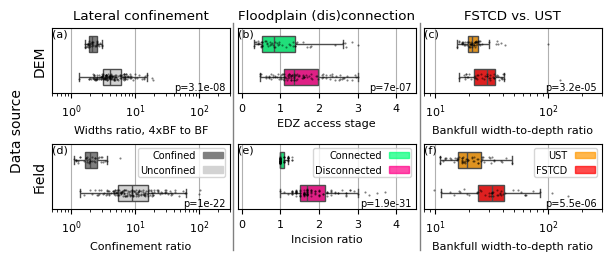

In [7]:
fig = reaches.plot_boxplots_paper()
#fig.savefig(hm_dir + 'figs/boxplots.tif', dpi=300, bbox_inches='tight')

In [10]:
reaches.src_edz_data.loc[reaches.src_edz_data.Ph2SedReg.isin(['CEFD','DEP']), 'el_edap_scaled'].describe()

count    52.000000
mean      1.080735
std       0.713206
min       0.318318
25%       0.534535
50%       0.834835
75%       1.376877
max       3.003003
Name: el_edap_scaled, dtype: float64

(0.0, 50.0)

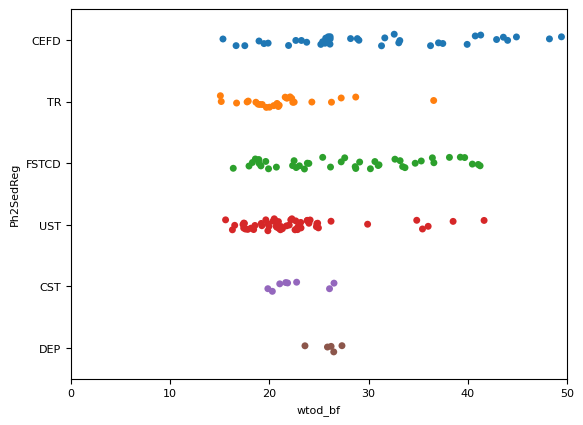

In [8]:
sns.stripplot(reaches.src_edz_data, x='wtod_bf', y='Ph2SedReg', hue='Ph2SedReg')  # 'rh_edap'
plt.gca().set_xlim([0,50])
#plt.gca().set_xscale('log')

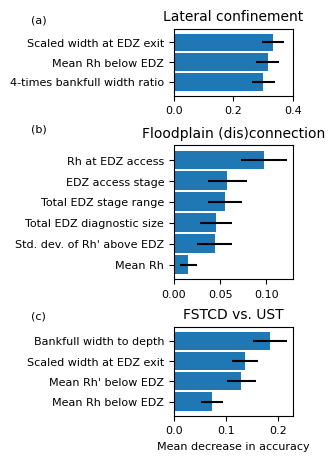

In [19]:
# permutation importances
pi_kwargs = {'n_repeats': 500, 'n_jobs': 10, 'scoring': 'balanced_accuracy'}

edz_fields_map1 = {
    'w_edep_scaled': 'Scaled width at EDZ exit',
    'rh_pre': 'Mean Rh below EDZ',
    'w_4timesbf_to_w_bf': '4-times bankfull width ratio',
}
edz_features1 = list(edz_fields_map1.keys())
X1 = reaches.src_edz_data[edz_features1]
y1 = reaches.src_edz_data['Ph2SedReg'].isin(['TR','CST']).astype(np.int8)
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X1, y1.to_numpy().ravel())
pi_results1 = reaches.rf.permutation_importances(clf, X1, y1, pi_kwargs=pi_kwargs)

edz_fields_map2 = {
    'cumulative_height': 'Total EDZ stage range', 
    'rhp_post_stdev': 'Std. dev. of Rh\' above EDZ',
    #'rh_pre': 'Mean Rh below EDZ',
    'el_edap_scaled': 'EDZ access stage',
    'Ave_Rh': 'Mean Rh',
    'rh_edap': 'Rh at EDZ access',
    'cumulative_volume': 'Total EDZ diagnostic size',
    #'rh_min': 'Rh at max lateral expansion',
}
edz_features2 = list(edz_fields_map2.keys())
chosen_regs = ['CEFD','FSTCD','DEP','UST']
mask = reaches.src_edz_data['Ph2SedReg'].isin(chosen_regs)
X2 = reaches.src_edz_data[edz_features2].loc[mask]
y2 = reaches.src_edz_data.Ph2SedReg.loc[mask].isin(['CEFD', 'DEP'])
#y2 = pd.Series(np.full(X2.shape[0], fill_value=np.nan), index=X2.index)
#y2[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['CEFD','DEP'])] = 0
#y2[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['FSTCD','UST'])] = 1
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X2, y2.to_numpy().ravel())
pi_results2 = reaches.rf.permutation_importances(clf, X2, y2, pi_kwargs=pi_kwargs)

edz_fields_map3 = {
    "wtod_bf": "Bankfull width to depth",
    'rhp_pre': 'Mean Rh\' below EDZ',
    'w_edep_scaled': 'Scaled width at EDZ exit',
    'rh_pre': 'Mean Rh below EDZ',
    #'rh_edap': 'Rh at EDZ access',
}
edz_features3 = list(edz_fields_map3.keys())
chosen_regs = ['FSTCD','UST']
mask = reaches.src_edz_data['Ph2SedReg'].isin(chosen_regs)
X3 = reaches.src_edz_data[edz_features3].loc[mask]
y3 = reaches.src_edz_data.Ph2SedReg.loc[mask].isin(['FSTCD'])
#y3 = pd.Series(np.full(X3.shape[0], fill_value=np.nan), index=X3.index)
#y3[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['FSTCD',])] = 0
#y3[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['UST',])] = 1
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X3, y3.to_numpy().ravel())
pi_results3 = reaches.rf.permutation_importances(clf, X3, y3, pi_kwargs=pi_kwargs)

fig,axs = plt.subplots(3,1, figsize=(3.,4.5), layout='constrained', height_ratios=[len(edz_features1), len(edz_features2), len(edz_features3)])
pirs=[pi_results1, pi_results2, pi_results3]
titles=['Lateral confinement', 'Floodplain (dis)connection', 'FSTCD vs. UST']
field_maps=[edz_fields_map1, edz_fields_map2, edz_fields_map3]
#for pir,ax,title,fmap in zip(pirs,axs,titles,field_maps):
#    bplot = pir.plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'), widths=0.5)
#    for patch in bplot['boxes']:
#        patch.set_facecolor("0.8")
#    ax.set_title(title, fontsize=10)
#    ax.set_xlabel('')
#    ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
#    yticklabs = ax.get_yticklabels()
#    yticklabels = [fmap[k.get_text()] for k in yticklabs]
#    ax.set_yticklabels(yticklabels)

for pir,ax,title,fmap in zip(pirs,axs,titles,field_maps):
    means = pir.mean(axis=0)
    stds = pir.std(axis=0)
    b = means.plot.barh(xerr=stds, ax=ax, capsize=0, width=0.9)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
    yticklabs = ax.get_yticklabels()
    yticklabels = [fmap[k.get_text()] for k in yticklabs]
    ax.set_yticklabels(yticklabels)
axs[0].set_xticks([0, 0.2, 0.4])
axs[-1].set_xlabel("Mean decrease in accuracy", fontsize=8)

#fig.canvas.draw()
#fig.set_layout_engine('none')

for ax,letter in zip(axs,['a','b','c']):
    ax.text(-1.2, 1.125, f'({letter})', ha='left', va='center', transform=ax.transAxes)

#fig.savefig(hm_dir + 'figs/permutation_importances.tif', dpi=300, bbox_inches='tight')

                    w_edep_scaled    rh_pre  w_4timesbf_to_w_bf
w_edep_scaled            1.000000 -0.329029            0.564788
rh_pre                  -0.329029  1.000000           -0.206547
w_4timesbf_to_w_bf       0.564788 -0.206547            1.000000
                    rh_edap  el_edap_scaled  cumulative_height  \
rh_edap            1.000000        0.666966           0.257179   
el_edap_scaled     0.666966        1.000000          -0.072960   
cumulative_height  0.257179       -0.072960           1.000000   
cumulative_volume  0.266193       -0.149074           0.680321   
rhp_post_stdev     0.038944       -0.050854          -0.095540   
Ave_Rh             0.381136       -0.261813           0.205356   

                   cumulative_volume  rhp_post_stdev    Ave_Rh  
rh_edap                     0.266193        0.038944  0.381136  
el_edap_scaled             -0.149074       -0.050854 -0.261813  
cumulative_height           0.680321       -0.095540  0.205356  
cumulative_volume    

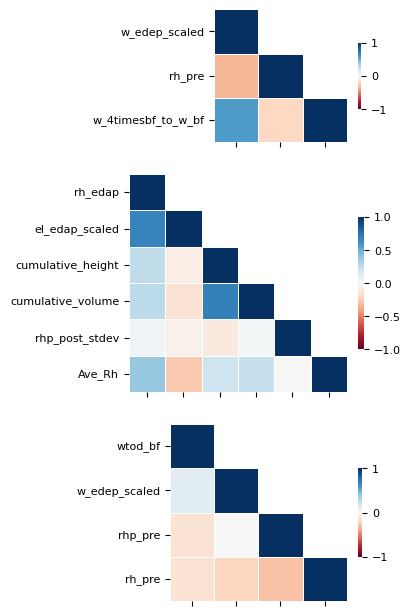

In [ ]:
xs = [X1[reversed(pi_results1.columns)], X2[reversed(pi_results2.columns)], X3[reversed(pi_results3.columns)]]
for x in xs:
    print(x.corr())
fig,axs = plt.subplots(3,1,figsize=(4.,6), layout='constrained', height_ratios=[len(edz_features1), len(edz_features2), len(edz_features3)])
for x,ax in zip(xs, axs):
    x = x.corr()
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[1]):
            x.iloc[i,j] = np.nan
    #_ = ax.matshow(x, cmap='RdBu', vmin=-1, vmax=1)
    #_ = sns.heatmap(x, cmap='RdBu', vmin=-1, vmax=1, ax=ax)
    mask = np.triu(np.ones_like(x, dtype=bool), k=1)
    sns.heatmap(x, mask=mask, cmap='RdBu', vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={'shrink': .5}, ax=ax, fmt='.2g')
    ax.set_xticks(ax.get_xticks(), labels=[])
    #fig.colorbar(_, ax=ax)

<Axes: >

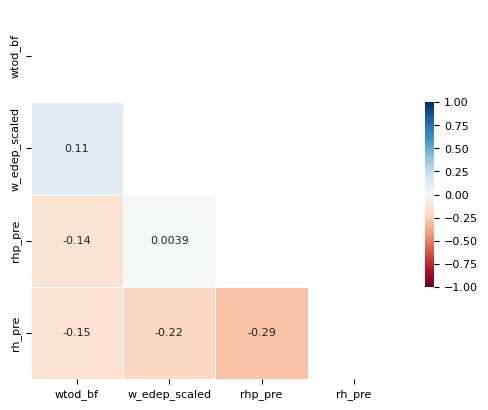

In [ ]:
mask = np.triu(np.ones_like(x, dtype=bool))
sns.heatmap(x, mask=mask, cmap='RdBu', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': .5}, annot=True)

Text(0.5, 0, 'Decrease in accuracy')

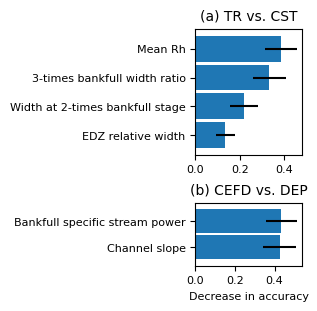

In [ ]:
# permutation importances the two minor cases

edz_fields_map4 = {
    'Ave_Rh': 'Mean Rh',
    'valley_confinement': 'EDZ relative width',
    'w_2timesbf': 'Width at 2-times bankfull stage',
    'w_3timesbf_to_w_bf': '3-times bankfull width ratio',
}
edz_features4 = list(edz_fields_map4.keys())
chosen_regs = ['TR','CST',]
mask = reaches.src_edz_data['Ph2SedReg'].isin(chosen_regs)
X4 = reaches.src_edz_data[edz_features4].loc[mask]
y4 = reaches.src_edz_data.Ph2SedReg.loc[mask].isin(['TR',])
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X4, y4.to_numpy().ravel())
pi_results4 = reaches.rf.permutation_importances(clf, X4, y4, pi_kwargs=pi_kwargs)

edz_fields_map5 = {
    'slope': 'Channel slope',
    'ssp_bf': 'Bankfull specific stream power'
}
edz_features5 = list(edz_fields_map5.keys())
chosen_regs = ['CEFD','DEP',]
mask = reaches.src_edz_data['Ph2SedReg'].isin(chosen_regs)
X5 = reaches.src_edz_data[edz_features5].loc[mask]
y5 = reaches.src_edz_data.Ph2SedReg.loc[mask].isin(['CEFD',])
#y2 = pd.Series(np.full(X2.shape[0], fill_value=np.nan), index=X2.index)
#y2[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['CEFD','DEP'])] = 0
#y2[reaches.src_edz_data['Ph2SedReg'].loc[mask].isin(['FSTCD','UST'])] = 1
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X5, y5.to_numpy().ravel())
pi_results5 = reaches.rf.permutation_importances(clf, X5, y5, pi_kwargs=pi_kwargs)

#fig,axs = plt.subplots(2,1, figsize=(3.,3), layout='constrained', height_ratios=[len(edz_features4), len(edz_features5)])
#pirs=[pi_results4, pi_results5]
#titles=['(a) TR vs. CST', '(b) CEFD vs. DEP',]
#field_maps=[edz_fields_map4, edz_fields_map5,]
#for pir,ax,title,fmap in zip(pirs,axs,titles,field_maps):
#    #bplot = pir.plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'), widths=0.5)
#    #for patch in bplot['boxes']:
#    #    patch.set_facecolor("0.8")
#    means = pir.mean(axis=0)
#    stds = pir.std(axis=0)
#    b = means.plot.barh(xerr=stds, ax=ax, capsize=0, width=0.9)
#    ax.set_title(title, fontsize=10)
#    ax.set_xlabel('')
#    ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
#    yticklabs = ax.get_yticklabels()
#    yticklabels = [fmap[k.get_text()] for k in yticklabs]
#    ax.set_yticklabels(yticklabels)
#
#axs[-1].set_xlabel("Decrease in accuracy", fontsize=8)
#fig.savefig(hm_dir + 'figs/permutation_importances_othersedregs.tif', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Decrease in accuracy')

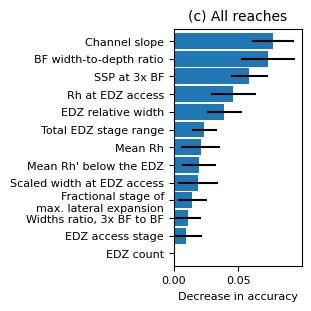

In [ ]:
pi_kwargs = {'n_repeats': 1000, 'n_jobs': 5, 'scoring': 'balanced_accuracy'}

edz_fields_map6 = {
    'rh_edap': 'Rh at EDZ access',
    'cumulative_height': 'Total EDZ stage range',
    'valley_confinement': 'EDZ relative width',
    'w_3timesbf_to_w_bf': 'Widths ratio, 3x BF to BF',
    'el_edap_scaled': 'EDZ access stage',
    'w_edap_scaled': 'Scaled width at EDZ access',
    'rhp_pre': 'Mean Rh\' below the EDZ',
    'edz_count': 'EDZ count',
    'wtod_bf': 'BF width-to-depth ratio',
    'ssp_3times_bf': 'SSP at 3x BF',
    'Ave_Rh': 'Mean Rh',
    'min_loc_ratio': 'Fractional stage of\nmax. lateral expansion',
    'slope': 'Channel slope'
}
edz_features6 = list(edz_fields_map6.keys())
X6 = reaches.src_edz_data[edz_features6]
labs = reaches.src_edz_data.Ph2SedReg.unique()
nums = np.arange(len(labs))
labs_nums_dict = dict(zip(labs, nums))
y6 = reaches.src_edz_data.Ph2SedReg.copy()
y6 = y6.map(labs_nums_dict).astype(np.int8)
clf = RandomForestClassifier(**reaches.rf.rf_kwargs)
clf.fit(X6, y6.to_numpy().ravel())
pi_results6 = reaches.rf.permutation_importances(clf, X6, y6, pi_kwargs=pi_kwargs)

#fig,ax = plt.subplots(1,1, figsize=(3.,3), layout='constrained',)
##bplot = pi_results6.plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'), widths=0.5)
##for patch in bplot['boxes']:
##    patch.set_facecolor("0.8")
#means = pi_results6.mean(axis=0)
#stds = pi_results6.std(axis=0)
#b = means.plot.barh(xerr=stds, ax=ax, capsize=0, width=0.9)
#ax.set_title('(c) All reaches', fontsize=10)
#ax.set_xlabel('')
#ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
#yticklabs = ax.get_yticklabels()
#yticklabels = [edz_fields_map6[k.get_text()] for k in yticklabs]
#ax.set_yticklabels(yticklabels)
#ax.set_xlabel("Decrease in accuracy", fontsize=8)
##fig.savefig(hm_dir + 'figs/permutation_importances_allreaches.tif', dpi=300, bbox_inches='tight')

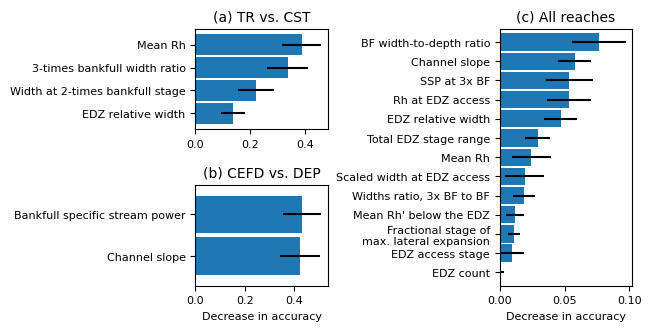

In [ ]:
fig = plt.figure(layout='constrained', figsize=(6.4,3.2))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])
axs = [ax1, ax2, ax3]

pirs=[pi_results4, pi_results5, pi_results6]
titles=['(a) TR vs. CST', '(b) CEFD vs. DEP', '(c) All reaches']
field_maps=[edz_fields_map4, edz_fields_map5, edz_fields_map6]
for pir,ax,title,fmap in zip(pirs,axs,titles,field_maps):
    #bplot = pir.plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'), widths=0.5)
    #for patch in bplot['boxes']:
    #    patch.set_facecolor("0.8")
    means = pir.mean(axis=0)
    stds = pir.std(axis=0)
    b = means.plot.barh(xerr=stds, ax=ax, capsize=0, width=0.9)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
    yticklabs = ax.get_yticklabels()
    yticklabels = [fmap[k.get_text()] for k in yticklabs]
    ax.set_yticklabels(yticklabels)

for ax in axs[1:]:
    ax.set_xlabel("Decrease in accuracy", fontsize=8)

#fig.savefig(hm_dir + 'figs/permutation_importances_supp.tif', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Value')

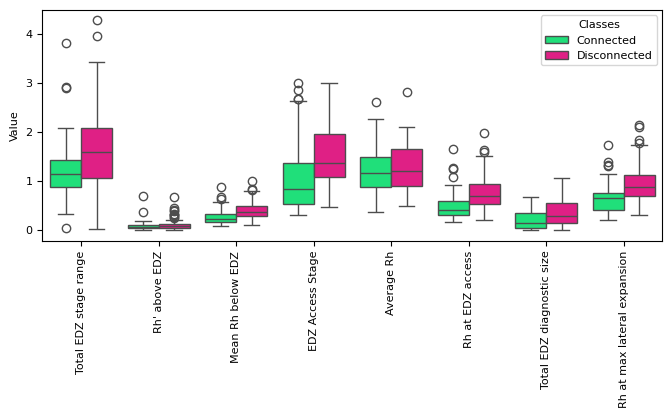

In [ ]:
# fields_map dict, class1, class2, label1, label2, colors=None
edz_fields_map = {
    'Ave_Rh': 'Mean Rh',
    'valley_confinement': 'EDZ relative width',
    'w_2timesbf': 'Width at 2-times bankfull stage',
    'w_3timesbf_to_w_bf': '3-times bankfull width ratio'
}
class1 = ['TR',]
class2 = ['CST',]
label1 = 'TR'
label2 = 'CST'
colors = [reaches.hexcolors_U2021['TR'], reaches.hexcolors_U2021['CST']]


edz_fields_map = {
    'cumulative_height': 'Total EDZ stage range', 
    'rhp_post_stdev': 'Rh\' above EDZ',
    'rh_pre': 'Mean Rh below EDZ',
    'el_edap_scaled': 'EDZ Access Stage',
    'Ave_Rh': 'Average Rh',
    'rh_edap': 'Rh at EDZ access',
    'cumulative_volume': 'Total EDZ diagnostic size',
    'rh_min': 'Rh at max lateral expansion',
}
class1 = ['CEFD', 'DEP']
class2 = ['FSTCD', 'UST']
label1 = 'Connected'
label2 = 'Disconnected'
colors = [reaches.hexcolors_groups[label1], reaches.hexcolors_groups[label2]]


edz_features = list(edz_fields_map.keys())
chosen_regs = class1 + class2  # ['TR','CST',]  # reaches.src_edz_data.Ph2SedReg.unique()
mask = reaches.src_edz_data['Ph2SedReg'].isin(chosen_regs)
X = reaches.src_edz_data[edz_features].loc[mask]
y = reaches.src_edz_data.Ph2SedReg.loc[mask].isin(class1)
X['Classes'] = y.map({True: label1, False: label2})
#X3['y'] = y3.map({False: 'UST', True: 'FSTCD'})
a = pd.melt(X, id_vars='Classes')
fig,ax = plt.subplots(1,1, figsize=(len(edz_features),3.))
sns.boxplot(a, x='variable', y='value', hue='Classes', ax=ax, palette=colors)
ax.set_xticks(ax.get_xticks(), [edz_fields_map[x.get_text()] for x in ax.get_xticklabels()], rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Value')
#ax.set_yscale('log')

# Transport vs. Confined Source and Transport reaches

Number of TR and CST reaches:
Ph2SedReg
TR     26
CST     8
Name: count, dtype: int64

Number of reaches with an EDZ:
Ph2SedReg
TR     12
CST     2
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.464
 All CV balanced_accuracy: [0.375      0.5        0.33333333 0.5        1.         0.33333333
 0.33333333 0.33333333]
 Out of bag training score: 0.486


<Axes: >

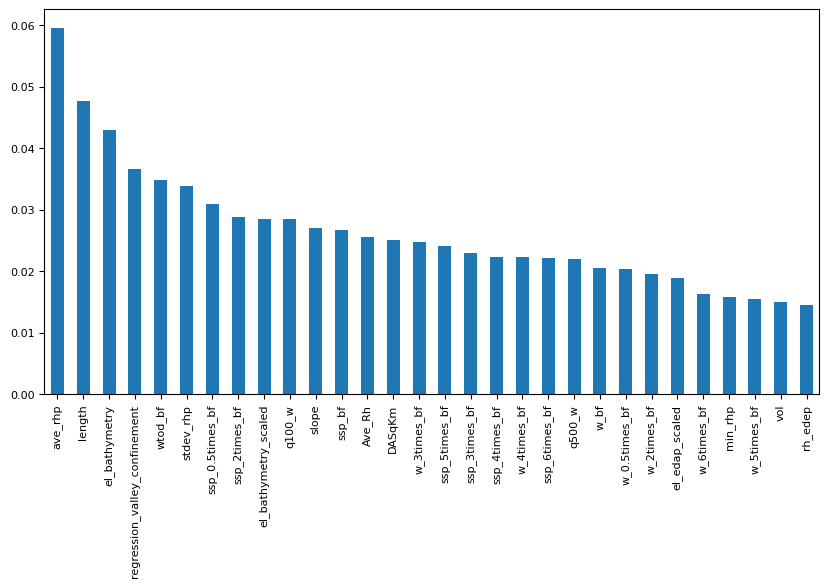

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(8), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')

idx = reaches.src_edz_data.Ph2SedReg.isin(['TR','CST'])
X = reaches.src_edz_data.loc[idx, cols]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['TR',]).astype(np.int8)

print('Number of TR and CST reaches:')
print(X.Ph2SedReg.value_counts())
print()
print('Number of reaches with an EDZ:')
print(X[X.edz_count > 0].Ph2SedReg.value_counts())
print()

clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y)
importances = pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
fig,axs = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
#importances.plot.bar(ax=axs[0])
importances.iloc[:30].plot.bar(ax=axs)

<Axes: xlabel='ssp_bf', ylabel='Count'>

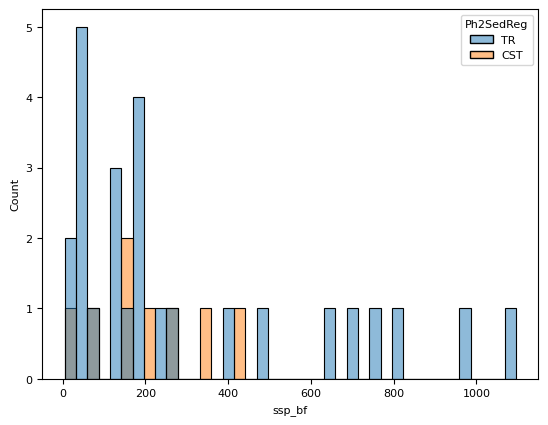

In [ ]:
fig,ax = plt.subplots(1,1)
sns.histplot(X, x='ssp_bf', hue='Ph2SedReg', ax=ax, bins=40)
#ax.set_title('Average Rh\'')
#ax.set_xlabel('')


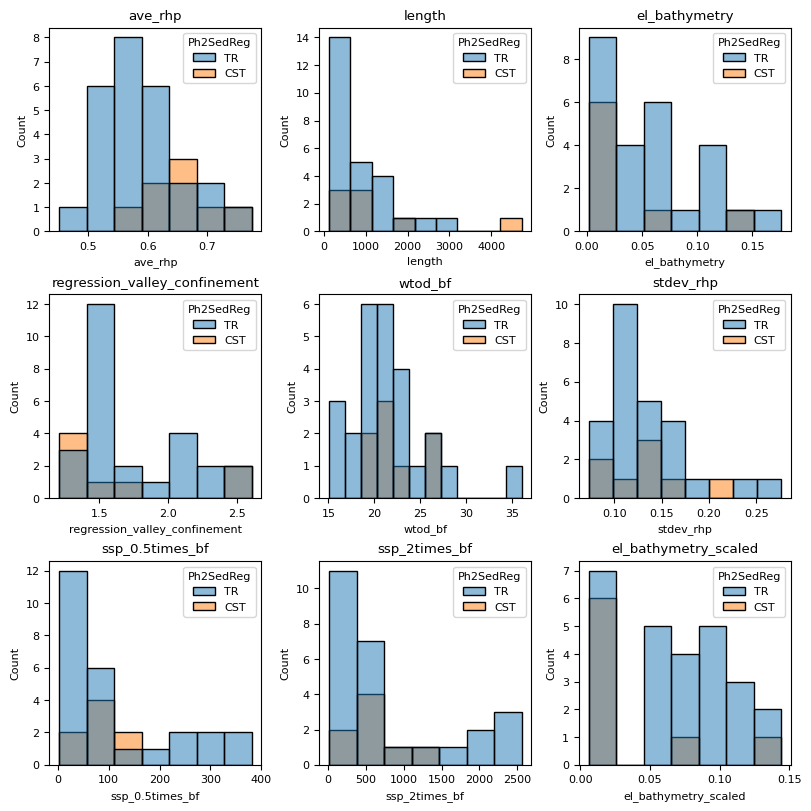

In [ ]:
cols_plot = list(importances.index[:9])

fig,axs = plt.subplots(3,3,figsize=(8.,8.),layout='constrained')
axs = axs.ravel()

for col,ax in zip(cols_plot,axs):
    sns.histplot(X, x=col, hue='Ph2SedReg', ax=ax)
    ax.set_title(col)

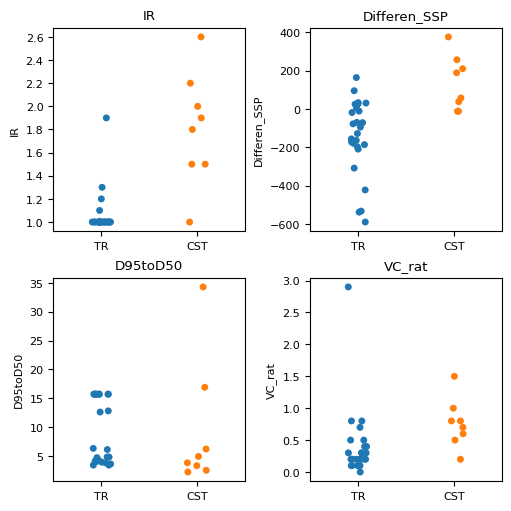

In [ ]:
# look at geomorphic breaks between TR, CST reaches

idx = reaches.src_edz_data.Ph2SedReg.isin(['TR','CST'])
X = reaches.src_edz_data[idx]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['TR',]).astype(np.int8)

idx = X.el_edap_scaled > 3
X.loc[idx, 'el_edap_scaled'] = np.nan

fig,axs = plt.subplots(2,2, figsize=(5,5.), layout='constrained')
axs = axs.ravel()
varplots = ['IR','Differen_SSP','D95toD50','VC_rat']
for ax,var in zip(axs,varplots):
    sns.stripplot(X, x='Ph2SedReg', y=var, hue='Ph2SedReg', ax=ax)
    ax.set_xlabel('')
    ax.set_title(var)
#axs[1].set_ylim([0,100])
#axs[3].set_ylim([0,100])


# CEFD vs DEP reaches

Number of CEFD and DEP reaches:
Ph2SedReg
CEFD    47
DEP      5
Name: count, dtype: int64

Number of reaches with an EDZ:
Ph2SedReg
CEFD    47
DEP      5
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.490
 All CV balanced_accuracy: [0.5     0.46875 0.5    ]
 Out of bag training score: 0.479


<Axes: >

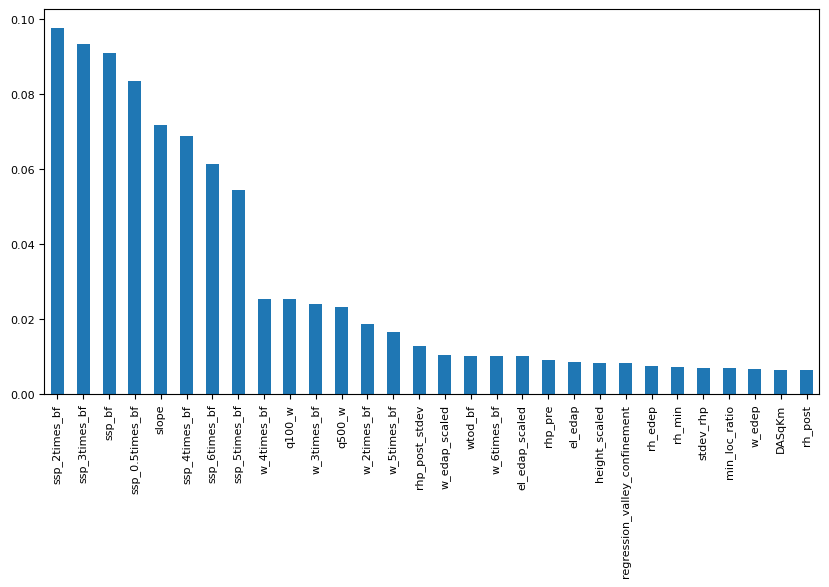

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(3), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')

idx = reaches.src_edz_data.Ph2SedReg.isin(['CEFD','DEP'])
X = reaches.src_edz_data.loc[idx, cols]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['CEFD',]).astype(np.int8)

print('Number of CEFD and DEP reaches:')
print(X.Ph2SedReg.value_counts())
print()
print('Number of reaches with an EDZ:')
print(X[X.edz_count > 0].Ph2SedReg.value_counts())
print()

clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y)
importances = pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
fig,axs = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
#importances.plot.bar(ax=axs[0])
importances.iloc[:30].plot.bar(ax=axs)

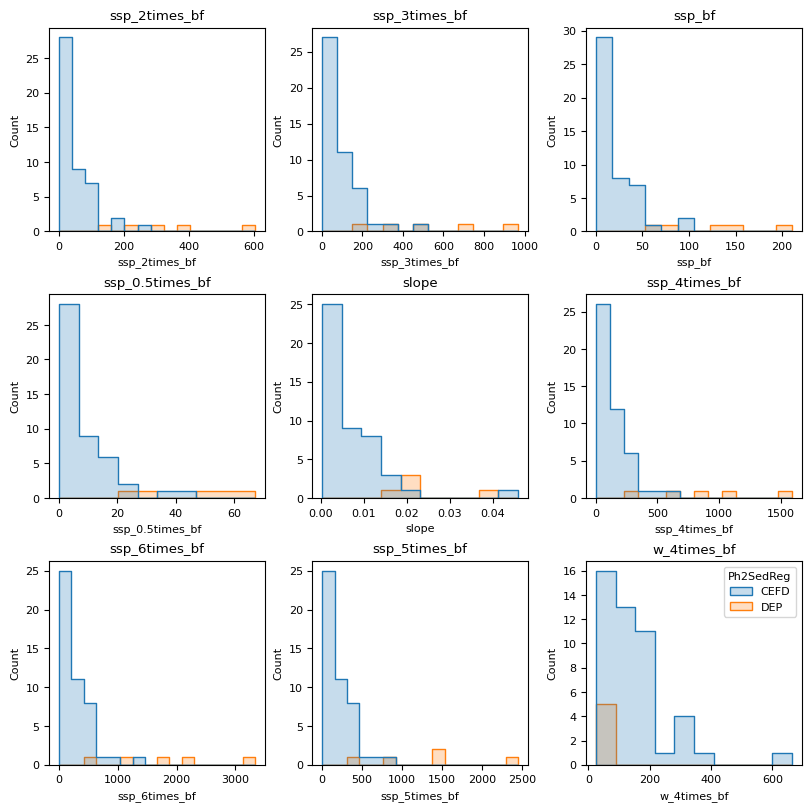

In [ ]:
cols_plot = list(importances.index[:9])

fig,axs = plt.subplots(3,3,figsize=(8.,8.),layout='constrained')
axs = axs.ravel()

for n,(col,ax) in enumerate(zip(cols_plot,axs)):
    leg = False
    if n == len(axs)-1:
        leg = True
    _ = sns.histplot(X, x=col, hue='Ph2SedReg', ax=ax, legend=leg, element='step')
    ax.set_title(col)

plt.show()

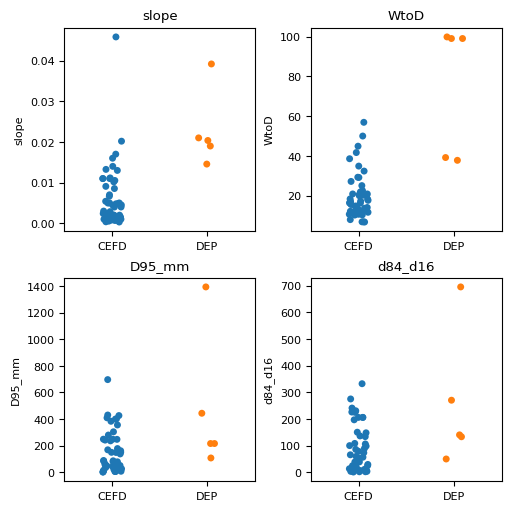

In [ ]:
# look at geomorphic breaks between CEFD, DEP reaches

idx = reaches.src_edz_data.Ph2SedReg.isin(['CEFD','DEP'])
X = reaches.src_edz_data[idx]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['CEFD',]).astype(np.int8)

fig,axs = plt.subplots(2,2, figsize=(5,5.), layout='constrained')
axs = axs.ravel()
varplots = ['slope','WtoD','D95_mm','d84_d16']
for ax,var in zip(axs,varplots):
    sns.stripplot(X, x='Ph2SedReg', y=var, hue='Ph2SedReg', ax=ax)
    ax.set_xlabel('')
    ax.set_title(var)
#axs[1].set_ylim([0,100])
#axs[3].set_ylim([0,100])


Text(0.5, 0, '')

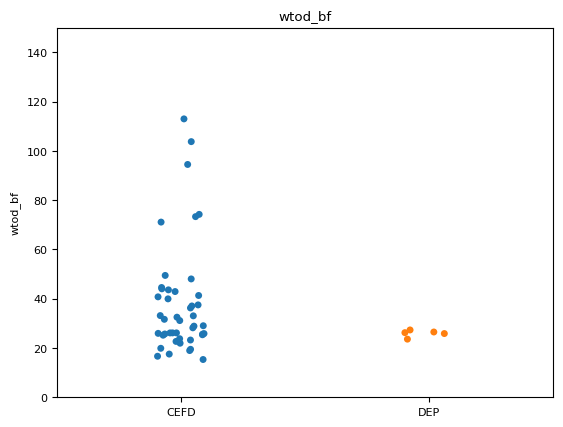

In [ ]:
fig,ax = plt.subplots(1,1)
sns.stripplot(X, x='Ph2SedReg', y='wtod_bf', hue='Ph2SedReg', ax=ax)
ax.set_ylim([0,150])
ax.set_title('wtod_bf')
ax.set_xlabel('')

Text(0.5, 1.0, 'EDZ access stage')

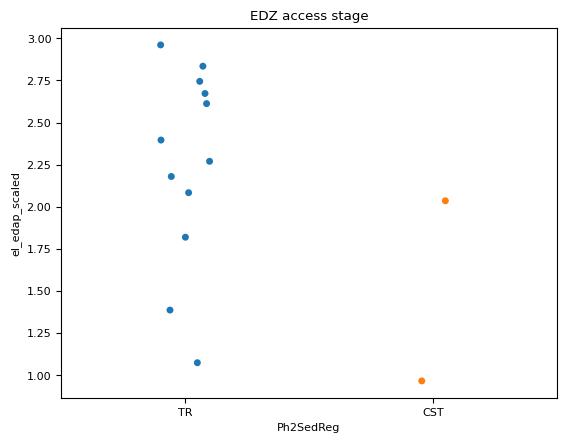

In [ ]:
# look at geomorphic breaks between TR, CST reaches
idx = reaches.src_edz_data.Ph2SedReg.isin(['TR','CST'])
X = reaches.src_edz_data[idx]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['TR',]).astype(np.int8)

fig,ax = plt.subplots(1,1)
sns.stripplot(X, x='Ph2SedReg', y='el_edap_scaled', hue='Ph2SedReg', ax=ax)
ax.set_title('EDZ access stage')

# All sediment regimes

Number of each type of reach:
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
TR       26
CST       8
DEP       5
Name: count, dtype: int64

Number of reaches with an EDZ:
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
TR       12
DEP       5
CST       2
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.422
 All CV balanced_accuracy: [0.50740741 0.43775253 0.39772727 0.30723906 0.45824916]
 Out of bag training score: 0.393


<Axes: >

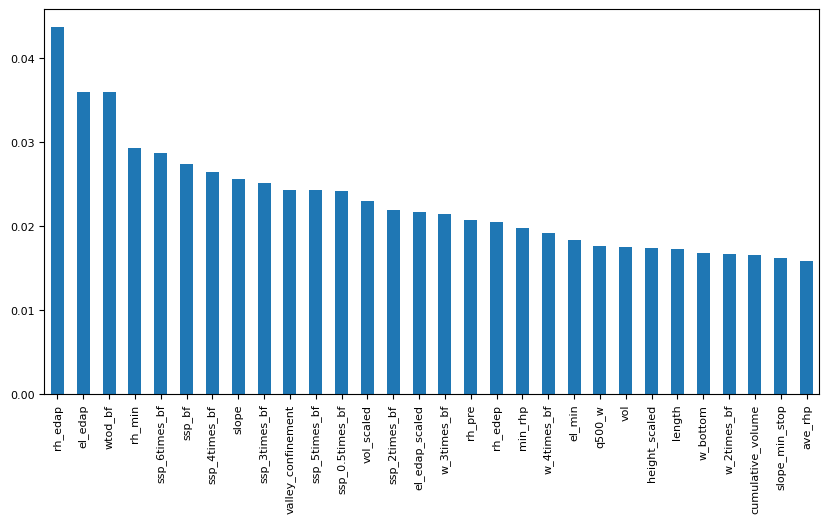

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(5), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')

X = reaches.src_edz_data[cols]
y = reaches.src_edz_data.Class.astype(np.int8)

print('Number of each type of reach:')
print(X.Ph2SedReg.value_counts())
print()
print('Number of reaches with an EDZ:')
print(X[X.edz_count > 0].Ph2SedReg.value_counts())
print()

clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y)
importances = pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
fig,axs = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
#importances.plot.bar(ax=axs[0])
importances.iloc[:30].plot.bar(ax=axs)

# Confined vs Unconfined

Number of each type of reach:
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
TR       26
CST       8
DEP       5
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.904
 All CV balanced_accuracy: [0.96875    1.         0.75       0.875      0.875      0.83333333
 0.83333333 1.         1.         0.9       ]
 Out of bag training score: 0.881


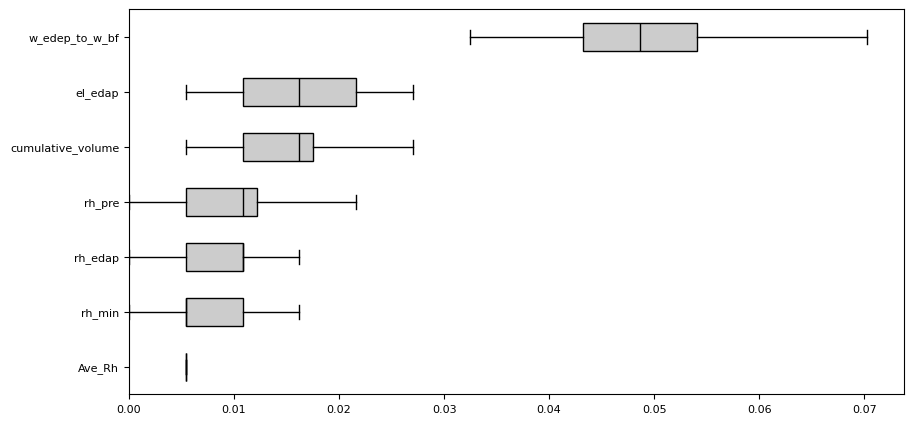

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(10), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

#cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')
#cols = ['Ph2SedReg','w_edep_scaled','valley_confinement','vol_scaled','w_6times_bf_to_w_bf', 'cumulative_volume', 'stdev_rhp',]  # 'vol','height','el_edap','rh_edap' 'cumulative_height'
#cols = ['Ph2SedReg','w_edep_scaled','valley_confinement','vol_scaled', 'cumulative_volume', 'stdev_rhp','w_6times_bf_to_w_bf','w_edep_to_w_bf']
cols = ['Ph2SedReg','rh_pre','rh_min','cumulative_volume','Ave_Rh','el_edap','rh_edap','w_edep_to_w_bf']

X = reaches.src_edz_data[cols]
y = reaches.src_edz_data.Ph2SedReg.isin(['TR', 'CST',]).astype(np.int8)

print('Number of each type of reach:')
print(X.Ph2SedReg.value_counts())
print()
#print('Number of reaches with an EDZ:')
#print(X[X.edz_count > 0].Ph2SedReg.value_counts())
#print()

clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y)
importances = rf.permutation_importances(clf, X.iloc[:,1:], y, pi_kwargs={'n_repeats': 100, 'n_jobs': 5}) # pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
fig,ax = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
#importances.plot.bar(ax=axs[0])
bplot = importances.plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'))
for patch in bplot['boxes']:
    patch.set_facecolor("0.8")
#ax.set_title(title, fontsize=10)
ax.set_xlabel('')
ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
yticklabs = ax.get_yticklabels()
#yticklabels = [fmap[k.get_text()] for k in yticklabs]
#ax.set_yticklabels(yticklabels)

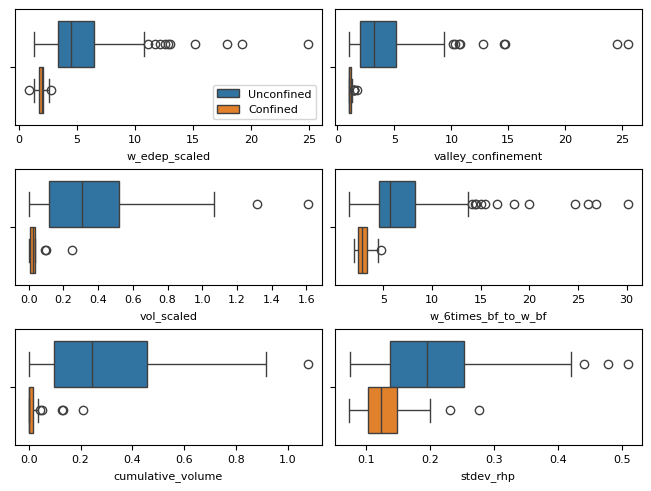

In [ ]:
fig,axs = plt.subplots(3,2,layout='constrained')
for ax,col in zip(axs.ravel(), X.iloc[:,1:]):
    sns.boxplot(X, x=col, hue=y, ax=ax, legend=False)
axs[0,0].legend(labels=['Unconfined','Confined'])

# Unconfined reaches

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(10), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')
cols = ['Ph2SedReg','rh_pre','rh_min','cumulative_volume','Ave_Rh','el_edap','rh_edap','w_edep_to_w_bf'] # ,'stdev_rhp', 'wtod_bf']

idx = reaches.src_edz_data.Ph2SedReg.isin(['CEFD','DEP','FSTCD','UST'])
X = reaches.src_edz_data.loc[idx, cols]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['CEFD','DEP',]).astype(np.int8)

print('Number of each type of reach:')
print(X.Ph2SedReg.value_counts())
print()
#print('Number of reaches with an EDZ:')
#print(X[X.edz_count > 0].Ph2SedReg.value_counts())
#print()

bas = []
for n in range(10):
    clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y, do_fit=False)
    bas.append(np.mean(cv_res['test_score']))
print(f'Mean of cross-validation means: {np.mean(bas)}')
print(f'Standard deviation: {np.std(bas)}')
print(f'Range: {np.min(bas)}, {np.max(bas)}')
# importances = rf.permutation_importances(clf, X.iloc[:,1:], y, pi_kwargs={'n_repeats': 100, 'n_jobs': 5}) # pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
# fig,ax = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
# #importances.plot.bar(ax=axs[0])
# bplot = importances[:20].plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'))
# for patch in bplot['boxes']:
#     patch.set_facecolor("0.8")
# #ax.set_title(title, fontsize=10)
# ax.set_xlabel('')
# ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
# yticklabs = ax.get_yticklabels()
# #yticklabels = [fmap[k.get_text()] for k in yticklabs]
# #ax.set_yticklabels(yticklabels)

Number of each type of reach:
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
DEP       5
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.746
 All CV balanced_accuracy: [0.7        0.61111111 0.8        0.75       0.9        0.5
 0.75       0.7        0.9        0.85      ]
 Mean CV balanced_accuracy: 0.742
 All CV balanced_accuracy: [0.75       0.72222222 0.7        0.8        0.7        0.65
 0.8        0.9        0.6        0.8       ]
 Mean CV balanced_accuracy: 0.724
 All CV balanced_accuracy: [0.61666667 0.8        0.75       0.6        0.5        0.8
 0.6        1.         0.8        0.77777778]
 Mean CV balanced_accuracy: 0.732
 All CV balanced_accuracy: [0.58333333 0.8        0.75       0.8        0.75       0.6
 0.9        0.8        0.75       0.58333333]
 Mean CV balanced_accuracy: 0.753
 All CV balanced_accuracy: [0.56666667 0.66666667 0.8        0.95       0.65       0.85
 0.75       0.8        0.75       0.75      ]
 Mean CV balanced_accuracy: 0.741
 All CV balanc

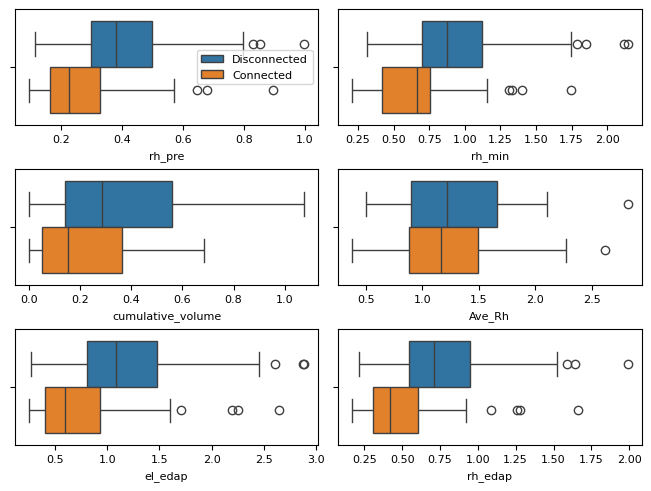

In [ ]:
fig,axs = plt.subplots(3,2,layout='constrained')
for ax,col in zip(axs.ravel(), X.iloc[:,1:]):
    sns.boxplot(X, x=col, hue=y, ax=ax, legend=False)
axs[0,0].legend(labels=['Disconnected','Connected'])

# Vertical (dis)connection

In [ ]:
rf = RandomForestCVHandler(rf_kwargs = {'n_estimators': 1000, 'oob_score': balanced_accuracy_score, 'class_weight': 'balanced', 'max_depth': 4,}, cv_kwargs={'cv': StratifiedKFold(10), 'return_estimator': True, 'scoring': 'balanced_accuracy'})

#cols = reaches.edz_data.columns.insert(0, 'Ph2SedReg')
cols = ['Ph2SedReg','wtod_bf','w_edep_scaled','rhp_pre','w_min','rh_pre','rh_edap'] # ,'stdev_rhp', 'wtod_bf']

idx = reaches.src_edz_data.Ph2SedReg.isin(['FSTCD','UST'])
X = reaches.src_edz_data.loc[idx, cols]
y = reaches.src_edz_data[idx].Ph2SedReg.isin(['UST',]).astype(np.int8)

print('Number of each type of reach:')
print(X.Ph2SedReg.value_counts())
print()
#print('Number of reaches with an EDZ:')
#print(X[X.edz_count > 0].Ph2SedReg.value_counts())
#print()

bas = []
for n in range(10):
    clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y, do_fit=False)
    bas.append(np.mean(cv_res['test_score']))
print(f'Mean of cross-validation means: {np.mean(bas)}')
print(f'Standard deviation: {np.std(bas)}')
print(f'Range: {np.min(bas)}, {np.max(bas)}')
# importances = rf.permutation_importances(clf, X.iloc[:,1:], y, pi_kwargs={'n_repeats': 500, 'n_jobs': 5}) # pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
# fig,ax = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
# #importances.plot.bar(ax=axs[0])
# bplot = importances[:20].plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'))
# for patch in bplot['boxes']:
#     patch.set_facecolor("0.8")
# #ax.set_title(title, fontsize=10)
# ax.set_xlabel('')
# ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
# yticklabs = ax.get_yticklabels()
# clf, cv_res = rf.rf_classify_with_cv(X.iloc[:,1:], y)
# importances = rf.permutation_importances(clf, X.iloc[:,1:], y, pi_kwargs={'n_repeats': 500, 'n_jobs': 5}) # pd.Series(clf.feature_importances_, index=X.iloc[:,1:].columns).sort_values(ascending=False)
# fig,ax = plt.subplots(1,1, figsize=(10.,5.)) #, width_ratios=[2,1])
# #importances.plot.bar(ax=axs[0])
# bplot = importances[:20].plot.box(return_type='dict', vert=False, fontsize=8, ax=ax, patch_artist=True, showfliers=False, boxprops=dict(color='k'), medianprops=dict(color='k'), whiskerprops=dict(color='k'), capprops=dict(color='k'))
# for patch in bplot['boxes']:
#     patch.set_facecolor("0.8")
# #ax.set_title(title, fontsize=10)
# ax.set_xlabel('')
# ax.set_xlim([0, ax.get_xlim()[1]])  # axvline(x=0, color="k",)
# yticklabs = ax.get_yticklabels()
# #yticklabels = [fmap[k.get_text()] for k in yticklabs]
# #ax.set_yticklabels(yticklabels)

Number of each type of reach:
Ph2SedReg
UST      56
FSTCD    43
Name: count, dtype: int64

 Mean CV balanced_accuracy: 0.738
 All CV balanced_accuracy: [0.64141414 0.74242424 0.7979798  0.83333333 0.67613636]
 Mean CV balanced_accuracy: 0.722
 All CV balanced_accuracy: [0.70833333 0.68686869 0.64141414 0.74242424 0.82954545]
 Mean CV balanced_accuracy: 0.711
 All CV balanced_accuracy: [0.60416667 0.6969697  0.68686869 0.88888889 0.67613636]
 Mean CV balanced_accuracy: 0.715
 All CV balanced_accuracy: [0.52083333 0.7979798  0.80808081 0.85353535 0.59659091]
 Mean CV balanced_accuracy: 0.709
 All CV balanced_accuracy: [0.75       0.8989899  0.65151515 0.67676768 0.56818182]
 Mean CV balanced_accuracy: 0.685
 All CV balanced_accuracy: [0.72916667 0.80808081 0.68686869 0.67676768 0.52272727]
 Mean CV balanced_accuracy: 0.725
 All CV balanced_accuracy: [0.58333333 0.83333333 0.7979798  0.64141414 0.76704545]
 Mean CV balanced_accuracy: 0.753
 All CV balanced_accuracy: [0.70833333 0.63131313

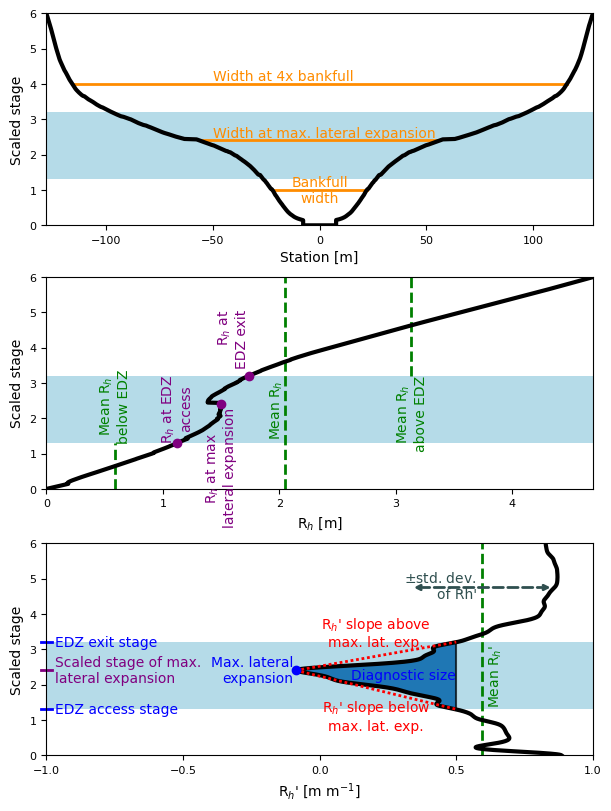

In [ ]:
def plot_edz_feature_descriptions(self, reach_id=str(14)):
    


reach_id = str(14)
#reaches.src_edz_data[reaches.src_edz_data.index=='14']
reach = reaches.src_edz_data.loc[reach_id]
length = reach['length']
el = reaches.el_scaled_data[reach_id].to_numpy()
rh = reaches.rh_data[reach_id].to_numpy()
rh_prime = reaches.rh_prime_data[reach_id].to_numpy()
rh_prime = gaussian_filter1d(rh_prime.T, 15).T
width = reaches.area_data[str(reach_id)].to_numpy() / length
width = width / 2
width = np.append(-width[::-1], width)
section_el = np.append(el[::-1], el)

el_edap = reach['el_edap_scaled']
el_edep = reach['el_edep_scaled']


fig,axs = plt.subplots(3,1, figsize=(6., 8.), layout='constrained')

ax = axs[0]
ax.plot(width, section_el, c='k', lw=3, zorder=10000)
ax.fill_between([width.min(), width.max()], el_edap, el_edep, fc='lightblue', alpha=0.9)
ax.set_xlim([width.min(), width.max()])
ax.set_xlabel('Station [m]', fontsize=10)

w4x_1 = np.argmin(np.abs(2*np.abs(width[:width.size//2]) - reach['w_4timesbf']))
w4x_2 = width.size - w4x_1
ax.plot([width[w4x_1], width[w4x_2]], [4., 4.,], c='darkorange', lw=2)
ax.text(-50, 4.1, 'Width at 4x bankfull', c='darkorange', fontsize=10)
max_exp = np.argmin(rh_prime)
max_exp_el = el[max_exp]
wmaxexp_1 = width[width.size//2 - max_exp]
wmaxexp_2 = width[width.size - (width.size//2 - max_exp)]
ax.plot([wmaxexp_1, wmaxexp_2], [max_exp_el, max_exp_el], c='darkorange', lw=2)
ax.text(-50, max_exp_el+0.1, 'Width at max. lateral expansion', c='darkorange', fontsize=10)
w_bf = reach['w_bf'] / 2
ax.plot([-w_bf, w_bf], [1, 1], c='darkorange', lw=2)
ax.text(0, 1.0, 'Bankfull\nwidth', c='darkorange', fontsize=10, ha='center', va='center')




ax = axs[1]
ax.plot(rh, el, c='k', lw=3, zorder=10000)
ax.fill_between([rh.min(), rh.max()], el_edap, el_edep, fc='lightblue', alpha=0.9)
ax.set_xlim([rh.min(), rh.max()])
ax.set_xlabel(r'R$_h$ [m]', fontsize=10)

ax.plot(rh[max_exp], max_exp_el, marker='o', c='purple', zorder=10001)
rh_edap = np.argmin(np.abs(el - el_edap))
rh_edep = np.argmin(np.abs(el - el_edep))
rh_mean = np.mean(rh)
rh_pre_mean = np.mean(rh[:rh_edap])
rh_post_mean = np.mean(rh[rh_edep:])
ax.plot(rh[rh_edap], el[rh_edap], marker='o', c='purple', zorder=10001)
ax.plot([rh_pre_mean, rh_pre_mean], [0, el[rh_edap]], c='g', ls='dashed', lw=2)
ax.plot(rh[rh_edep], el[rh_edep], marker='o', c='purple', zorder=10001)
ax.plot([rh_post_mean, rh_post_mean], [el[rh_edep], 6], c='g', ls='dashed', lw=2)
ax.plot([rh_mean, rh_mean], [0, 6], c='g', ls='dashed', lw=2)
ax.text(rh_pre_mean, el_edap, r'Mean R$_h$'+f'\nbelow EDZ', rotation=90, ha='center', va='bottom', c='g', fontsize=10)
ax.text(rh_mean, (el_edap + el_edep) / 2, r'Mean R$_h$', rotation=90, ha='right', va='center', c='g', fontsize=10)
ax.text(rh_post_mean, el_edep, r'Mean R$_h$'+f'\nabove EDZ', rotation=90, ha='center', va='top', c='g', fontsize=10)
ax.text(rh[rh_edap], el_edap, r'R$_h$ at EDZ'+f'\naccess', rotation=90, ha='center', va='bottom', c='purple', fontsize=10)
ax.text(rh[max_exp], 0.6, r'R$_h$ at max'+f'\nlateral expansion', rotation=90, ha='center', va='center', c='purple', fontsize=10)
ax.text(rh[rh_edep], el_edep+0.2, r'R$_h$ at'+f'\nEDZ exit', rotation=90, ha='right', va='bottom', c='purple', fontsize=10)



ax = axs[2]
ax.plot(rh_prime, el, c='k', lw=3, zorder=10000)
ax.fill_between([-1,1], el_edap, el_edep, fc='lightblue', alpha=0.9)
start = np.argmin(np.abs(el - el_edap))
stop = np.argmin(np.abs(el - el_edep))
ax.fill_betweenx(el[start:stop], 0.5, rh_prime[start:stop])
ax.vlines(0.5, el[start], el[stop], ls='solid', color='k', alpha=0.7)
ax.set_xlim([-1, 1])
ax.set_xticks([-1.0, -0.5, -0., 0.5, 1.])
ax.set_xlabel(r"R$_{h}$' [m m$^{-1}$]", fontsize=10)

rh_prime_max_exp = rh_prime[max_exp]
rh_prime_mean = np.mean(rh_prime)
rh_prime_std = np.std(rh_prime)
rh_prime_pre_mean = np.mean(rh_prime[:rh_edap])
rh_prime_post_mean = np.mean(rh_prime[rh_edep:])

ax.plot(rh_prime_max_exp, max_exp_el, c='b', marker='o', zorder=10002)
ax.plot([rh_prime_max_exp, 0.5], [max_exp_el, el_edep], c='r', ls=(0, (1, 1)), lw=2, zorder=10001)
ax.plot([rh_prime_max_exp, 0.5], [max_exp_el, el_edap], c='r', ls=(0, (1, 1)), lw=2, zorder=10001)
ax.axvline(rh_prime_mean, ls='dashed', c='green', lw=2)
ax.annotate('', [rh_prime_mean-rh_prime_std, 4.75], [rh_prime_mean+rh_prime_std, 4.75], arrowprops=dict(arrowstyle='<|-|>', color='darkslategrey', ls='dashed', lw=2))
#ax.plot([rh_prime_pre_mean, rh_prime_pre_mean], [0, el_edap], ls='dashed', c='green', lw=2)
#ax.plot([rh_prime_post_mean, rh_prime_post_mean], [el_edep, 6], ls='dashed', c='green', lw=2)
ax.plot([-1.02, -0.98], [el_edap, el_edap], c='b', lw=2, clip_on=False)
ax.plot([-1.02, -0.98], [max_exp_el, max_exp_el], c='purple', lw=2, clip_on=False)
ax.plot([-1.02, -0.98], [el_edep, el_edep], c='b', lw=2, clip_on=False)

#ax.text(rh_prime_pre_mean-0.03, el_edap, r"Mean R$_h$'"+f'\nbelow EDZ', rotation=90, ha='left', va='bottom', c='g', fontsize=10)
ax.text(rh_prime_mean+0.02, 2.25, r"Mean R$_h$'", rotation=90, ha='left', va='center', c='g', fontsize=10)
#ax.text(rh_prime_post_mean-0.02, el_edep+0.4, r"Mean R$_h$'"+f'\nabove EDZ', rotation=90, ha='left', va='top', c='g', fontsize=10)
ax.text(-0.97, el_edap, 'EDZ access stage', c='b', ha='left', va='center', fontsize=10)
ax.text(-0.97, max_exp_el, 'Scaled stage of max.\nlateral expansion', c='purple', ha='left', va='center', fontsize=10)
ax.text(-0.97, el_edep, 'EDZ exit stage', c='b', ha='left', va='center', fontsize=10)
ax.text((0.5+rh_prime_max_exp)/2, el_edap+0.3, r"R$_h$' slope below"+f'\nmax. lat. exp.', c='r', ha='center', va='top', fontsize=10)
ax.text((0.5+rh_prime_max_exp)/2, el_edep-0.2, r"R$_h$' slope above"+f'\nmax. lat. exp.', c='r', ha='center', va='bottom', fontsize=10)
ax.text(rh_prime_max_exp-0.01, max_exp_el, 'Max. lateral\nexpansion', c='b', ha='right', va='center', fontsize=10)
ax.text(rh_prime_mean-0.02, 4.8, r"$\pm$std. dev."+"\nof Rh'", c='darkslategrey', ha='right', va='center', fontsize=10)
ax.text(0.5, (el_edap+el_edep)/2, 'Diagnostic size', c='b', ha='right', va='center', fontsize=10)

for ax in axs:
    ax.set_ylim([0,6])
    ax.set_ylabel('Scaled stage', fontsize=10)
plt.show()